**CIFAR-10 Dataset**


---


In this notebook, I am using keras to make a Convolutional Neural 
Network using VGG19 architecture to make an image prediction model on CIFAR-10 Dataset.



In [1]:
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.initializers import he_normal
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Explanation of Model parameters** 

---

num_classes : The number of classes in dataset are 10.

batch_size : number of training examples in one iteration - 128.

epochs : one pass of full training set - 100. 

iterations : number of batches used per epoch - 391.


In [2]:
num_classes  = 10
batch_size   = 128
epochs       = 100
iterations   = 391
dropout      = 0.5
weight_decay = 0.0001
log_filepath = r'./vgg19_retrain_logs/'


In [3]:
from keras import backend as K
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.compat.v1.ConfigProto
    #sess = tf.Session(config=config)

In [4]:
def scheduler(epoch):
    if epoch < 80:
        return 0.1
    if epoch < 160:
        return 0.01
    return 0.001

Instead of using random weights, I used the saved standard VGG19 architecture weights available on GitHub.

In [5]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
filepath = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH, cache_subdir='models')

In [6]:
# data loading
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**Making Sense of Labels**

---

0 : airplane                
1 : automobile           
2 : bird                    
3 : cat            
4 : deer            
5 : dog               
6 : frog           
7 : horse            
8 : ship          
9 : truck

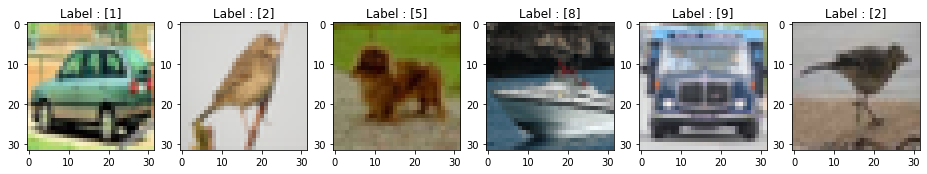

In [7]:
f, ax = plt.subplots(1, 6)
f.set_size_inches(16, 6)
i=0
while(i<6):
  j=np.random.randint(0,len(y_train))
  img = x_train[j]
  ax[i].imshow(img)
  ax[i].set_title("Label : "+str(y_train[j]))
  i=i+1

plt.show()

**Preprocessing the Data**

---

Step 1 : Splitting the dataset into train and test set.

Step 2 : One-hot encoding the labels of train and test set.

Step 3 : Converting the images into float for training.

Step 4 : Modifying the RGB values of images.

In [8]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train[:,:,:,0] = (x_train[:,:,:,0]-123.680)
x_train[:,:,:,1] = (x_train[:,:,:,1]-116.779)
x_train[:,:,:,2] = (x_train[:,:,:,2]-103.939)
x_test[:,:,:,0] = (x_test[:,:,:,0]-123.680)
x_test[:,:,:,1] = (x_test[:,:,:,1]-116.779)
x_test[:,:,:,2] = (x_test[:,:,:,2]-103.939)


In [9]:
# build model
model = Sequential()

**THE VGG19 ARCHITECTURE**

![](https://drive.google.com/uc?export=view&id=1ZI76TqkGtzSnrlhp5w1X22LdOcUkFvZ_)

In [10]:
# Block 1
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block1_conv1', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block1_conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

In [11]:
# Block 2
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block2_conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block2_conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

In [12]:
# Block 3
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block3_conv4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))


In [13]:
# Block 4
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block4_conv4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

In [14]:
# Block 5
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='block5_conv4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

In [15]:
# model modification for cifar-10
model.add(Flatten(name='flatten'))
model.add(Dense(4096, use_bias = True, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='fc_cifa10'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(4096, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='fc2'))  
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))      
model.add(Dense(10, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal(), name='predictions_cifa10'))        
model.add(BatchNormalization())
model.add(Activation('softmax'))

In [16]:
# load pretrained weight from VGG19 by name      
model.load_weights(filepath, by_name=True)

# -------- optimizer setting -------- #
sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [17]:
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

In [18]:
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(horizontal_flip=True,
        width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)

datagen.fit(x_train)

Using real-time data augmentation.


In [19]:
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))

model.save('retrain.h5')

Epoch 1/100
391/391 [==============================] - 167s 426ms/step - loss: 2.0664 - accuracy: 0.6530 - val_loss: 2.5564 - val_accuracy: 0.5642
Epoch 2/100
391/391 [==============================] - 155s 397ms/step - loss: 1.6709 - accuracy: 0.7576 - val_loss: 1.9186 - val_accuracy: 0.6699
Epoch 3/100
391/391 [==============================] - 155s 397ms/step - loss: 1.4723 - accuracy: 0.7940 - val_loss: 1.5054 - val_accuracy: 0.7714
Epoch 4/100
391/391 [==============================] - 157s 402ms/step - loss: 1.3306 - accuracy: 0.8149 - val_loss: 1.4438 - val_accuracy: 0.7635
Epoch 5/100
391/391 [==============================] - 156s 398ms/step - loss: 1.2220 - accuracy: 0.8291 - val_loss: 1.4686 - val_accuracy: 0.7478
Epoch 6/100
391/391 [==============================] - 155s 397ms/step - loss: 1.1234 - accuracy: 0.8443 - val_loss: 1.3804 - val_accuracy: 0.7588
Epoch 7/100
391/391 [==============================] - 156s 398ms/step - loss: 1.0431 - accuracy: 0.8539 - val_loss: 1

**Model Summary**

---

After 100 epochs, we see that the accuracy for our validation set is 93.16%, that means I can confidently say that the model is a reliable one.

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)       

**VISUALIZATIONS**

---

Now that the model is trained, we will observe some visualizations to see the trends better.

First, we see the accuracy and loss vs epoch plot, for both, test and training set.

See how it was about to hit plateau, so 100 epochs seems like a good choice.

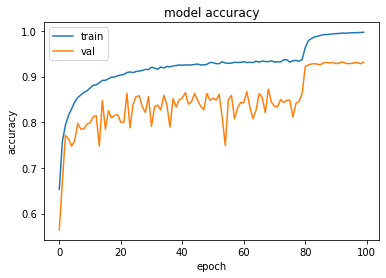

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

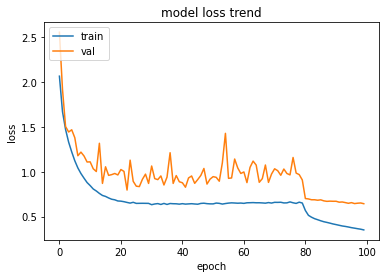

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Predictions**

---

Now, I used model.predict() function to predict the value of test set and compare it to actual values. 

Plotting a heat map gives us a better insight than confusion matrix as we don't need to look at numbers, colors are more catchy and understandable.

As the [1,1] has high values(bright color), it means that the values of examples that were actually 1 and also predicted 1 are high.

Same goes for all diagonal values which signifies that our model is reliable.

x-axis : Predicted value
y-axis : Actual value

In [23]:
y_pred=model.predict(x_test)

In [24]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

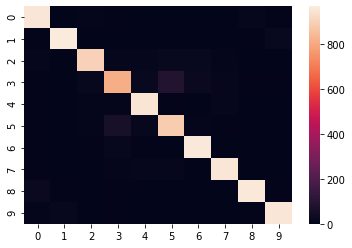

In [25]:
sns.heatmap(matrix)

In [26]:
y_predclass=y_pred.argmax(axis=1)
y_test=y_test.argmax(axis=1)
correct_pred=[y_test[i]==y_predclass[i] for i in range(len(y_test))]

**Random Predictions**

---

I plotted random predictions against their actual ones and the x-axis label tells us the probability of prediction by our model.

The first plot shows the right predictions. Check how probability is always above 0.95 which shows that the model is confident on its predictions.

The second plot shows a few wrong predictions with their probabilities.

If we want that kind of probabilities, we can use signmoid which returns probabilities which always sum upto 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


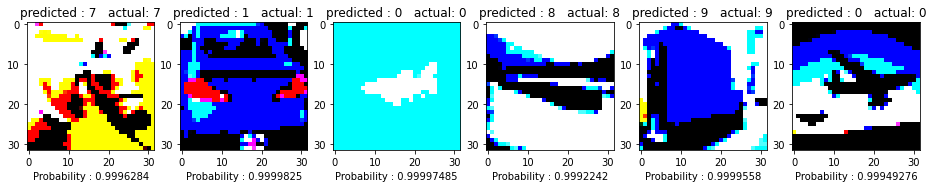

In [27]:
f, axarr = plt.subplots(1, 6)
f.set_size_inches(16, 6)
i=0
while(i<6):
  j=np.random.randint(0,len(y_test))
  if(correct_pred[j]==1):
    img = x_test[j]
    axarr[i].imshow(img)
    axarr[i].set_title("predicted : "+str(y_predclass[j])+"   actual: "+str(y_test[j]))
    axarr[i].set_xlabel("Probability : "+str(y_pred[j,y_predclass[j]]))
    i=i+1
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


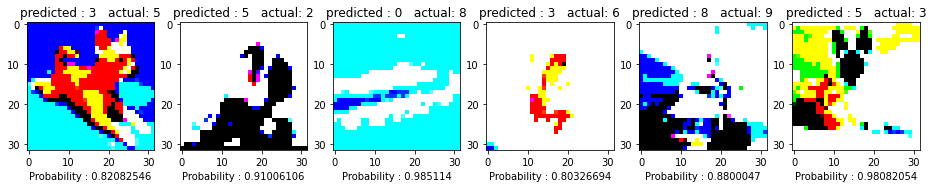

In [28]:
f, ax = plt.subplots(1, 6)
f.set_size_inches(16, 6)
i=0
while(i<6):
  j=np.random.randint(0,len(y_test))
  if(correct_pred[j]==0):
    img = x_test[j]
    ax[i].imshow(img)
    ax[i].set_title("predicted : "+str(y_predclass[j])+"   actual: "+str(y_test[j]))
    ax[i].set_xlabel("Probability : "+str(y_pred[j,y_predclass[j]]))
    i=i+1
plt.show()

**CONCLUSION**

---

The model shows 93.16% accuracy which says that we can trust the model. With all the visualizations, it gives us a better insight on the accuracy and predictions.

The challenge was really fun to do, I started with CNN which yeilded 70% then went on to InceptionV3 which gave 79%. Finally, after some research, this was good enough and tweaking the iterations and epochs, this one had 93% accuracy.

I hope you like the work. :)